# Shakespeare Quote Generator

**First lets pull the complete works of Shakespeare - they're available on the MIT website**

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2021-10-22 10:13:31.103821: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Num GPUs Available:  1


2021-10-22 10:13:31.960125: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-22 10:13:31.960505: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-22 10:13:32.015821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 10:13:32.016284: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.8GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-10-22 10:13:32.016300: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-22 10:13:32.017490: I tensorflow/stream_executor/platfor

In [2]:
%config Completer.use_jedi = False

In [3]:
import requests

In [4]:
r = requests.get("https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt")
r.raise_for_status()
next(r.iter_lines(decode_unicode=True))

'This is the 100th Etext file presented by Project Gutenberg, and'

**We can use regex to pull out of the quotes from people**

In [5]:
import re
import pandas as pd
re_quote = re.compile(r"\n  ([A-Z][A-Z\s]+)\.(.+(?:\n    [^ ].+)*)")
df = pd.DataFrame(re_quote.findall(r.text), columns=["name", "quote"])
df.head()

,name,quote
0,COUNTESS,"In delivering my son from me, I bury a second..."
1,BERTRAM,"And I in going, madam, weep o'er my father's ..."
2,LAFEU,"You shall find of the King a husband, madam; ..."
3,COUNTESS,What hope is there of his Majesty's amendment?
4,LAFEU,"He hath abandon'd his physicians, madam; unde..."


**Let's clean up the names by making them title case, and removing extra whitespace from the quotes**

In [6]:
df["name"] = df["name"].str.title()
df.head()

,name,quote
0,Countess,"In delivering my son from me, I bury a second..."
1,Bertram,"And I in going, madam, weep o'er my father's ..."
2,Lafeu,"You shall find of the King a husband, madam; ..."
3,Countess,What hope is there of his Majesty's amendment?
4,Lafeu,"He hath abandon'd his physicians, madam; unde..."


In [7]:
df["quote"] = df["quote"].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
df.head()

,name,quote
0,Countess,"In delivering my son from me, I bury a second ..."
1,Bertram,"And I in going, madam, weep o'er my father's d..."
2,Lafeu,"You shall find of the King a husband, madam; y..."
3,Countess,What hope is there of his Majesty's amendment?
4,Lafeu,"He hath abandon'd his physicians, madam; under..."


In [8]:
# Get statistics on number of words per quote
df["quote"].apply(lambda x: len(x.split(" "))).describe()

count    24840.000000
mean        25.106562
std         36.413863
min          1.000000
25%          6.000000
50%         13.000000
75%         28.000000
max        588.000000
Name: quote, dtype: float64

**Convert our quotes into sequences of the entire corpus, using SpaCy to tokenize**

In [9]:
import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

In [10]:
# Since average quote length is approximately 25 words, let's use that as our quote training length, with one target word
train_len = 25+1

# Let's create a list of tokens in the entire corpus
tokens = [token.text for quote in df["quote"].values for token in nlp(quote)if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n']

# Create a moving window of words
text_seq = []
for i in range(train_len, len(tokens)):
    text_seq.append(tokens[i-train_len:i])

In [32]:
" ".join(tokens)

"In delivering my son from me I bury a second husband And I in going madam weep o'er my father 's death anew but I must attend his Majesty 's command to whom I am now in ward evermore in subjection You shall find of the King a husband madam you sir a father He that so generally is at all times good must of necessity hold his virtue to you whose worthiness would stir it up where it wanted rather than lack it where there is such abundance What hope is there of his Majesty 's amendment He hath abandon'd his physicians madam under whose practices he hath persecuted time with hope and finds no other advantage in the process but only the losing of hope by time This young gentlewoman had a father- O that ' had ' how sad a passage ' tis!-whose skill was almost as great as his honesty had it stretch'd so far would have made nature immortal and death should have play for lack of work Would for the King 's sake he were living I think it would be the death of the King 's disease How call'd you the

In [12]:
text_seq

[['In',
  'delivering',
  'my',
  'son',
  'from',
  'me',
  'I',
  'bury',
  'a',
  'second',
  'husband',
  'And',
  'I',
  'in',
  'going',
  'madam',
  'weep',
  "o'er",
  'my',
  'father',
  "'s",
  'death',
  'anew',
  'but',
  'I',
  'must'],
 ['delivering',
  'my',
  'son',
  'from',
  'me',
  'I',
  'bury',
  'a',
  'second',
  'husband',
  'And',
  'I',
  'in',
  'going',
  'madam',
  'weep',
  "o'er",
  'my',
  'father',
  "'s",
  'death',
  'anew',
  'but',
  'I',
  'must',
  'attend'],
 ['my',
  'son',
  'from',
  'me',
  'I',
  'bury',
  'a',
  'second',
  'husband',
  'And',
  'I',
  'in',
  'going',
  'madam',
  'weep',
  "o'er",
  'my',
  'father',
  "'s",
  'death',
  'anew',
  'but',
  'I',
  'must',
  'attend',
  'his'],
 ['son',
  'from',
  'me',
  'I',
  'bury',
  'a',
  'second',
  'husband',
  'And',
  'I',
  'in',
  'going',
  'madam',
  'weep',
  "o'er",
  'my',
  'father',
  "'s",
  'death',
  'anew',
  'but',
  'I',
  'must',
  'attend',
  'his',
  'Majesty'

In [13]:
" ".join(text_seq[0])

"In delivering my son from me I bury a second husband And I in going madam weep o'er my father 's death anew but I must"

In [14]:
" ".join(text_seq[1])

"delivering my son from me I bury a second husband And I in going madam weep o'er my father 's death anew but I must attend"

**We can also now fit and transform every sequence to a tokenizer**

In [15]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
import numpy as np

In [16]:
len(text_seq)

640444

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_seq)
sequences = np.array(tokenizer.texts_to_sequences(text_seq))

In [18]:
vocab_size = len(tokenizer.word_counts)
vocab_size

23244

In [19]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'i': 3,
 'to': 4,
 'of': 5,
 'you': 6,
 'a': 7,
 'my': 8,
 'that': 9,
 'in': 10,
 'not': 11,
 'is': 12,
 'it': 13,
 'for': 14,
 'me': 15,
 "'s": 16,
 "'": 17,
 'with': 18,
 'be': 19,
 'your': 20,
 'he': 21,
 'his': 22,
 'this': 23,
 'but': 24,
 'have': 25,
 'as': 26,
 'him': 27,
 'thou': 28,
 'so': 29,
 'will': 30,
 'what': 31,
 'we': 32,
 'do': 33,
 'no': 34,
 'thy': 35,
 'all': 36,
 'shall': 37,
 'by': 38,
 'her': 39,
 'if': 40,
 'are': 41,
 'our': 42,
 'thee': 43,
 'good': 44,
 'on': 45,
 'now': 46,
 'lord': 47,
 'sir': 48,
 'from': 49,
 'o': 50,
 'they': 51,
 'come': 52,
 'at': 53,
 "'ll": 54,
 'let': 55,
 'would': 56,
 'she': 57,
 'or': 58,
 'more': 59,
 'well': 60,
 'here': 61,
 'which': 62,
 'was': 63,
 'there': 64,
 'am': 65,
 'then': 66,
 'how': 67,
 'their': 68,
 'can': 69,
 'when': 70,
 'than': 71,
 'them': 72,
 'love': 73,
 'hath': 74,
 'man': 75,
 'one': 76,
 'like': 77,
 'upon': 78,
 'say': 79,
 'go': 80,
 'an': 81,
 'us': 82,
 'were': 83,
 'make': 

In [20]:
sequences

array([[   10,  8353,     8, ...,    24,     3,    90],
       [ 8353,     8,   151, ...,     3,    90,   666],
       [    8,   151,    49, ...,    90,   666,    22],
       ...,
       [  261,   101,    32, ...,    83, 23244, 13501],
       [  101,    32,    85, ..., 23244, 13501,   633],
       [   32,    85, 13500, ..., 13501,   633,   126]])

In [21]:
for i in sequences[0]:
    print(f'{i} : {tokenizer.index_word[i]}')

10 : in
8353 : delivering
8 : my
151 : son
49 : from
15 : me
3 : i
1662 : bury
7 : a
869 : second
318 : husband
2 : and
3 : i
10 : in
742 : going
186 : madam
585 : weep
416 : o'er
8 : my
115 : father
16 : 's
123 : death
8352 : anew
24 : but
3 : i
90 : must


**Break each sequence into X and y, where y is the last word to predict on and X is everything before it**

In [22]:
from keras.utils import to_categorical
X = sequences[:,:-1]
y = sequences[:,-1]
n_words = X.shape[1]
n_words

25

In [23]:
len(X[0])

25

In [24]:
len(y)

640444

**Perform train test split**

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**We can now create our model**

In [81]:
def create_model(vocab_size, n_words):
    model = Sequential()
    # Embedding layer
    model.add(Embedding(vocab_size, train_len-1, input_length=n_words))
    
    # LSTM layers
    model.add(Bidirectional(LSTM(256, input_shape=(vocab_size, n_words), return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    
    # Dense Layer
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

**Let's also add in early stopping to save us some time and overtraining**

In [93]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5, restore_best_weights=False, monitor="val_accuracy")

**Let's also take checkpoints of our training**

In [94]:
checkpoint_path = "quotes_model.ckpt"

# Create a callback that saves the model's weights
cp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1
)

**Time to create and fit our model instance**

In [95]:
model = create_model(vocab_size+1, n_words)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 25, 25)            581125    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 25, 512)           577536    
_________________________________________________________________
dropout_20 (Dropout)         (None, 25, 512)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 23245)             5973965   
Total params: 7,920,082
Trainable params: 7,920,082
Non-trainable params: 0
___________________________________________

In [96]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    validation_data=(X_test, y_test),
    epochs=100, 
    verbose=1, 
    callbacks=[es, cp]
)

Epoch 1/100
4003/4003 [==============================] - 70s 17ms/step - loss: 6.9212 - accuracy: 0.0359 - val_loss: 6.2846 - val_accuracy: 0.0755

Epoch 00001: saving model to quotes_model.ckpt
Epoch 2/100
4003/4003 [==============================] - 67s 17ms/step - loss: 6.1747 - accuracy: 0.0805 - val_loss: 6.1349 - val_accuracy: 0.0902

Epoch 00002: saving model to quotes_model.ckpt
Epoch 3/100
4003/4003 [==============================] - 67s 17ms/step - loss: 5.9433 - accuracy: 0.0946 - val_loss: 6.0506 - val_accuracy: 0.0985

Epoch 00003: saving model to quotes_model.ckpt
Epoch 4/100
4003/4003 [==============================] - 68s 17ms/step - loss: 5.7430 - accuracy: 0.1039 - val_loss: 6.0255 - val_accuracy: 0.1032

Epoch 00004: saving model to quotes_model.ckpt
Epoch 5/100
4003/4003 [==============================] - 68s 17ms/step - loss: 5.5990 - accuracy: 0.1104 - val_loss: 6.0158 - val_accuracy: 0.1058

Epoch 00005: saving model to quotes_model.ckpt
Epoch 6/100
4003/4003 [==

**Plot training history**

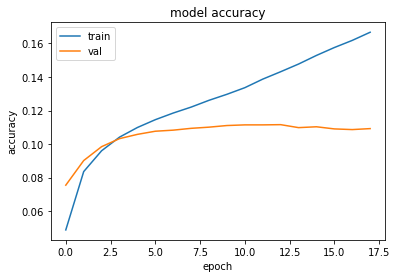

In [97]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

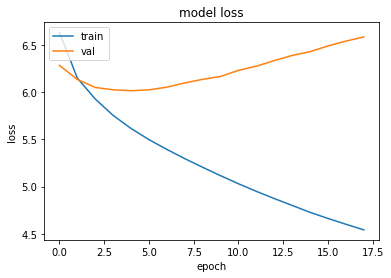

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Let's save our model and tokenizer**

In [99]:
import pickle

In [100]:
tokenizer_path = 'tokenizer.pkl'
model_path = "quotes_model"

In [101]:
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [102]:
model.save(model_path)

2021-10-22 14:53:13.190275: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: quotes_model/assets


INFO:tensorflow:Assets written to: quotes_model/assets


**If you want to skip model training earlier, don't save over the tokenizer or the model above and uncomment these lines:**

In [103]:
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

In [104]:
model = tf.keras.models.load_model(model_path)

**We can now create a function to generate quotes, using random ngrams from the original corpus if no seed is provided**

In [105]:
import nltk
from nltk import word_tokenize
import random
from keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
nlp_sents = spacy.load("en_core_web_sm")

def get_ngrams(n):
    return [ngram for ngram in [' '.join(word_tokenize(quote)[:n]) for quote in df["quote"].values] if len(ngram) <= vocab_size]

def generate_quote(seed=None, seed_len=5, max_words=26, random_state=None):
    # If no seed, generate seed from first words of corpus
    if not seed:
        ngrams = get_ngrams(seed_len)
        if random_state is not None:
            random.seed(random_state)
        random_index = random.randint(0, len(ngrams))
        seed = ngrams[random_index]
    
    # Iterate through until either a sentence break has been found or we reach the max sentence length
    input_text = seed
    print(input_text)
    while len(input_text.split(" ")) < max_words:
        # Encode seed into sequence
        encoded = tokenizer.texts_to_sequences([input_text])[0]
        
        # Pad sequence
        padded = pad_sequences([encoded], maxlen=train_len-1, truncating='pre')
        
        # Predict word index probabilities
        i = np.argmax(model.predict(padded), axis=-1)[0]
        
        # Get word for that index
        word = tokenizer.index_word[i]
            
        # Update the sequence of input text (shifting one over with the new word)
        input_text += ' ' + word
        
        # If the predicted word is an end of sentence, break
        if word in '\n!.?\t':
            break
        elif nlp_sents(input_text).has_annotation("SENT_END"):
            break
            
    return input_text

[nltk_data] Downloading package punkt to /home/david/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [106]:
generate_quote(random_state=1)

Uncertain favour !


"Uncertain favour ! and his own estate is to be fear'd and lov'd the king and the king of york and lancaster and lancaster and all"

In [107]:
generate_quote(random_state=42)

Gramercy , lovely Lucius .


"Gramercy , lovely Lucius . mindless world hath smooth'd him with winds and toil'd their unbreathed memories with his sleeve and i will not be so"

In [108]:
generate_quote(random_state=101)

Happily met ; the happier


'Happily met ; the happier and the king of york the king of york the king of york the king of york the king of york'

In [109]:
generate_quote(random_state=3000)

O , why should nature


"O , why should nature be so far in the field and with the world and the king 's son and his own son and his"